In [1]:
import nltk
import requests

import pandas as pd
from pandas import DataFrame
import numpy as np

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from string import punctuation

import matplotlib
import matplotlib.pyplot as plt

import re

import json

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/luisricardoferraz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/luisricardoferraz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Criar função para requisitar a etiquetagem do PortService-Br
    # Importante observar que, quando a palavra é desconhecida, o PortService-Br não etiqueta adequadamente a palavra
    # Palavras desconhecidas incluem nomes próprios, abreviações, palavras com erros de ortografia, e caracteres especiais e sinais de pontuação que não são conhecidos pelo etiquetador Freeling
# Criar função para somar as etiquetas por tipo

# Incluir dados das etiquetas no DataFrame
# Criar função para plotar os valores num gráfico usando Matplotlib

# Aplicar os procedimentos em strings com stopwords
# Remover as stopwords
# Aplicar os procedimentos em strings sem stopwords

# O problema que surgiu no gráfico tem relação com a etiquetagem repetida das palavras. Existe uma diferença entre
# etiquetar as palavras antes ou depois da remoção das stopwords. Para resultados mais confiáveis, é melhor
# que a etiquetagem seja feita antes de tal remoção.

In [3]:
def sumDifferentTags(jsonObject):    
    tagsDictionary = {
        'A': 0,
        'C': 0,
        'D': 0,
        'N': 0,
        'P': 0,
        'R': 0,
        'S': 0,
        'V': 0,
        'Z': 0,
        'W': 0,
        'I': 0,
        'F': 0,
        'UNKNOWN': 0,
        'TOTAL': 0
    }
    
    tagsDictionary['TOTAL'] = len(jsonObject)
    
    for word in jsonObject:
        if word['lemma'] != '<unknown>':
            if word['poss'][0] in tagsDictionary:
                tagsDictionary[word['poss'][0]] += 1
            else:
                tagsDictionary['UNKNOWN'] += 1
        else:
            tagsDictionary['UNKNOWN'] += 1

    return tagsDictionary

In [4]:
def cleanDataframeColumns(dataframe):
    numberList = []
    textList = []
    percentageList = []
    i = 0
    while i < dataframe.shape[0]:
        numberList.append(0)
        textList.append('')
        percentageList.append(0.0)
        i+=1
    
    textArrayBefore = ['extendedSynopsis']
    for column in textArrayBefore:
        dataframe[column] = textList
    
    numberArrayBefore = ['adjective_before','conjunction_before','determiner_before','noun_before','pronoun_before','adverb_before','adposition_before','verb_before','number_before','date_before','interjection_before','punctuation_before','unknown_before','total_before']
    for column in numberArrayBefore:
        dataframe[column] = numberList
        
    textArrayAfter = ['synopsisWithoutStopwords']
    for column in textArrayAfter:
        dataframe[column] = textList
    
    numberArrayAfter = ['adjective_after','conjunction_after','determiner_after','noun_after','pronoun_after','adverb_after','adposition_after','verb_after','number_after','date_after','interjection_after','punctuation_after','unknown_after','total_after']
    for column in numberArrayAfter:
        dataframe[column] = numberList
    
    dataframe['percentageOfUnknownWords'] = percentageList

In [5]:
def executePosTagging(dataframe):
    i = 0
    while i < dataframe.shape[0]:
        text = dataframe.sinopse.iloc[i]
        
        try:
            result = json.loads(text.replace('\'','\"'))
            dictionary = sumDifferentTags(result)

            dataframe.extendedSynopsis.iloc[i] = recreateSynopsis(result)

            dataframe.adjective_before.iloc[i] = dictionary.get('A')
            dataframe.conjunction_before.iloc[i] = dictionary.get('C')
            dataframe.determiner_before.iloc[i] = dictionary.get('D')
            dataframe.noun_before.iloc[i] = dictionary.get('N')
            dataframe.pronoun_before.iloc[i] = dictionary.get('P')
            dataframe.adverb_before.iloc[i] = dictionary.get('R')
            dataframe.adposition_before.iloc[i] = dictionary.get('S')
            dataframe.verb_before.iloc[i] = dictionary.get('V')
            dataframe.number_before.iloc[i] = dictionary.get('Z')
            dataframe.date_before.iloc[i] = dictionary.get('W')
            dataframe.interjection_before.iloc[i] = dictionary.get('I')
            dataframe.punctuation_before.iloc[i] = dictionary.get('F')
            dataframe.unknown_before.iloc[i] = dictionary.get('UNKNOWN')
            dataframe.total_before.iloc[i] = dictionary.get('TOTAL')

            resultWithoutStopwords = removeStopwordsFromSynopsis(result)
            dictionaryWithoutStopwords = sumDifferentTags(resultWithoutStopwords)

            dataframe.synopsisWithoutStopwords.iloc[i] = recreateSynopsis(resultWithoutStopwords)

            dataframe.adjective_after.iloc[i] = dictionaryWithoutStopwords.get('A')
            dataframe.conjunction_after.iloc[i] = dictionaryWithoutStopwords.get('C')
            dataframe.determiner_after.iloc[i] = dictionaryWithoutStopwords.get('D')
            dataframe.noun_after.iloc[i] = dictionaryWithoutStopwords.get('N')
            dataframe.pronoun_after.iloc[i] = dictionaryWithoutStopwords.get('P')
            dataframe.adverb_after.iloc[i] = dictionaryWithoutStopwords.get('R')
            dataframe.adposition_after.iloc[i] = dictionaryWithoutStopwords.get('S')
            dataframe.verb_after.iloc[i] = dictionaryWithoutStopwords.get('V')
            dataframe.number_after.iloc[i] = dictionaryWithoutStopwords.get('Z')
            dataframe.date_after.iloc[i] = dictionaryWithoutStopwords.get('W')
            dataframe.interjection_after.iloc[i] = dictionaryWithoutStopwords.get('I')
            dataframe.punctuation_after.iloc[i] = dictionaryWithoutStopwords.get('F')
            dataframe.unknown_after.iloc[i] = dictionaryWithoutStopwords.get('UNKNOWN')
            dataframe.total_after.iloc[i] = dictionaryWithoutStopwords.get('TOTAL')

            dataframe.percentageOfUnknownWords.iloc[i] = (dictionary.get('UNKNOWN')/dictionary.get('TOTAL'))*100
        except:
            pass
        
        i += 1

In [6]:
stopwordsList = stopwords.words('portuguese')

def removeStopwordsFromSynopsis(jsonObject):
    synopsisWithoutStopwords = [word for word in jsonObject if word['token'] not in stopwordsList and word['lemma'] != '<unknown>' and word['poss'][0] in ['A', 'N']]
    return synopsisWithoutStopwords

In [7]:
def recreateSynopsis(response):
    allWords = []
    for item in response:
        allWords.append(item['token'])
    return " ".join(allWords)

In [2]:
#Count number of characters in each string
def countCharactersInEachString(df, column):
    charactersCount = []
    for synopsis in df[column]:
        charactersCount.append(len(str(synopsis)))
    return charactersCount

#Count number of words in each string
def countWordsInEachString(df, column):
    wordsCount = []
    for synopsis in df[column]:
        words = word_tokenize(str(synopsis))
        wordsCount.append(len(words))
    return wordsCount

#Extract some basic statistics about synopsis
def extractBasicStatisticsAboutSynopsis(arrayOfSizes):
    synopsisLength = np.array(arrayOfSizes)
    basicStatistics = "\t"   
    basicStatistics += "Arithmetic Mean: " + str(np.mean(synopsisLength)) + "\n\t"
    basicStatistics += "Median: " + str(np.median(synopsisLength)) + "\n\t"
    basicStatistics += "Highest Value: " + str(np.max(synopsisLength)) + "\n\t"
    basicStatistics += "Lowest Value: " + str(np.min(synopsisLength)) + "\n\t"
    basicStatistics += "Mid-range: " + str((np.max(synopsisLength)-np.min(synopsisLength))/2) + "\n\t"
    basicStatistics += "Variance: " + str(np.var(synopsisLength,ddof=1)) + "\n\t"
    basicStatistics += "Standard Deviation: " + str(np.std(synopsisLength,ddof=1)) + "\n\t"
    return basicStatistics

def extractPercentilesAboutSynopsis(arrayOfSizes):
    synopsisLength = np.array(arrayOfSizes)
    percentiles = "Percentiles: " + "\n\t"
    count = 0.5
    while count <= 100:
        percentiles += "Percentile " + str(count) + ": " + str(np.percentile(arrayOfSizes,count)) + "\n\t"
        count += 0.5
    return percentiles

#Extract some statistics about this Dataset
def extractStatisticsFromSynopsis(dataframe, title, column):
    log = title + "\n\n"
    log += "Shape of Dataset: " + str(dataframe.shape[0]) + " rows and " + str(dataframe.shape[1]) + " columns" + "\n\n"
    log += "Statistics of Synopsis Length (Characters):" + "\n"
    charactersCount = countCharactersInEachString(dataframe, column)
    log += extractBasicStatisticsAboutSynopsis(charactersCount) + "\n"
    log += extractPercentilesAboutSynopsis(charactersCount) + "\n"
    log += "Statistics of Synopsis Length (Words):" + "\n"
    wordsCount = countWordsInEachString(dataframe, column)
    log += extractBasicStatisticsAboutSynopsis(wordsCount) + "\n"
    log += extractPercentilesAboutSynopsis(wordsCount) + "\n"
    return log

In [3]:
filePath = '/Users/luisricardoferraz/book-similarity/test/tutorial/tutorial/spiders/synopsis-preprocessing/'

In [4]:
#Import CSV file to a DataFrame
df = pd.read_csv(filePath+'sinopsesProcessadas.csv')
df = df.drop(['Unnamed: 0'],1)

In [8]:
df['sinopse'][1755]

"[{'token': 'em', 'poss': 'SPS', 'lemma': 'em'}, {'token': 'uma', 'poss': 'DI0', 'lemma': 'um'}, {'token': 'terra', 'poss': 'NCFS', 'lemma': 'terra'}, {'token': 'onde', 'poss': 'RG', 'lemma': 'onde'}, {'token': 'o', 'poss': 'DA0', 'lemma': 'o'}, {'token': 'verão', 'poss': 'NCMS', 'lemma': 'verão'}, {'token': 'pode', 'poss': 'VMI', 'lemma': 'poder'}, {'token': 'durar', 'poss': 'VMN', 'lemma': 'durar'}, {'token': 'décadas', 'poss': 'NCFP', 'lemma': 'década'}, {'token': 'e', 'poss': 'CC', 'lemma': 'e'}, {'token': 'o', 'poss': 'DA0', 'lemma': 'o'}, {'token': 'inverno', 'poss': 'NCMS', 'lemma': 'inverno'}, {'token': 'toda', 'poss': 'DI0', 'lemma': 'todo'}, {'token': 'uma', 'poss': 'DI0', 'lemma': 'um'}, {'token': 'vida', 'poss': 'NCFS', 'lemma': 'vida'}, {'token': 'os', 'poss': 'DA0', 'lemma': 'o'}, {'token': 'problemas', 'poss': 'NCMP', 'lemma': 'problema'}, {'token': 'estão', 'poss': 'VMI', 'lemma': 'estar'}, {'token': 'apenas', 'poss': 'RG', 'lemma': 'apenas'}, {'token': 'começando', 'po

In [11]:
cleanDataframeColumns(df)
executePosTagging(df)

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!
deu erro!


In [12]:
df['synopsisWithoutStopwords']

0        jovem garota brasileira curso inglês exterior ...
1        resgate primeira palavra tiros cima última coi...
2        substantivo cela prisão verbo mentiras fáceis ...
3                court s king play lords book times j over
4        dias monstro cenas noite ano novo noite noite ...
5        atual próxima dias luta feminina silêncio ensu...
6        histórias contos fadas crianças sentido forma ...
7        passos garota linda dezessete anos quilos infâ...
8        forma leveza graça simples fato ocupações sent...
9        thriller luta secreta bem mal pessoas habilida...
10       crônicas gelo fogo personagens presentes quint...
11       homem simples vida modesta coração suficiente ...
12       oitavo volume tensão fantasia universo deliran...
13       diana mulher maravilha personagens história qu...
14       início século xx jovem glória amor contrário a...
15       mulher maravilha diana filha deusa diana irmãs...
16       paraíso inferno brasil terra furacões terremot.

In [13]:
df.to_csv(filePath+'dataSetComPosTaggingERemocaoDeStopWords.csv')

In [14]:
with open(filePath+'logDataSetComPosTaggingERemocaoDeStopWords.txt','w') as log:
    log.write(extractStatisticsFromSynopsis(df, "Statistics of Dataset - PosTagging and StopWords Removal", 'sinopse'))

In [15]:
#Import CSV file to a DataFrame
df = pd.read_csv(filePath+'dataSetComPosTaggingERemocaoDeStopWords.csv')
df = df.drop(['Unnamed: 0'],1)

In [17]:
df = df.dropna(axis=0,how='any',subset=['extendedSynopsis'],inplace=False)

df.to_csv(filePath+'dataSetComPosTaggingBemSucedido.csv')
with open(filePath+'logDataSetComPosTaggingBemSucedido.txt','w') as log:
    log.write(extractStatisticsFromSynopsis(df, "Statistics of Dataset - PosTagging Successful", 'sinopse'))

In [18]:
df.shape

(10204, 33)

In [19]:
df = df[df['percentageOfUnknownWords'] <= 29]

df.to_csv(filePath+'dataSetComPalavrasEstrangeirasRemovidas.csv')
with open(filePath+'logDataSetComPalavrasEstrangeirasRemovidas.txt','w') as log:
    log.write(extractStatisticsFromSynopsis(df, "Statistics of Dataset - Foreign Words Removed", 'sinopse'))

In [21]:
#Import CSV file to a DataFrame
df = pd.read_csv(filePath+'dataSetComPalavrasEstrangeirasRemovidas.csv')
df = df.drop(['Unnamed: 0'],1)

In [22]:
dfBeforeStopWordsRemoval = df[['titulo', 'sinopse', 'extendedSynopsis', 'adjective_before', 'conjunction_before', 'determiner_before', 'noun_before', 'pronoun_before', 'adverb_before', 'adposition_before', 'verb_before', 'number_before', 'date_before', 'interjection_before', 'punctuation_before', 'unknown_before', 'total_before', 'percentageOfUnknownWords']]
dfBeforeStopWordsRemoval.to_csv(filePath+'dataSetComPosTaggingAntesDaRemocaoDeStopwords.csv')
with open(filePath+'logDataSetComPosTaggingAntesDaRemocaoDeStopwords.txt','w') as log:
    log.write(extractStatisticsFromSynopsis(dfBeforeStopWordsRemoval, "Statistics of Dataset - PosTagging before StopWords Removal", 'extendedSynopsis'))

dfAfterStopWordsRemoval = df[['titulo', 'sinopse', 'synopsisWithoutStopwords', 'adjective_after', 'conjunction_after', 'determiner_after', 'noun_after', 'pronoun_after', 'adverb_after', 'adposition_after', 'verb_after', 'number_after', 'date_after', 'interjection_after', 'punctuation_after', 'unknown_after', 'total_after']]
dfAfterStopWordsRemoval.to_csv(filePath+'dataSetComPosTaggingDepoisDaRemocaoDeStopwords.csv')
with open(filePath+'logDataSetComPosTaggingDepoisDaRemocaoDeStopwords.txt','w') as log:
    log.write(extractStatisticsFromSynopsis(dfAfterStopWordsRemoval, "Statistics of Dataset - PosTagging after StopWords Removal", 'synopsisWithoutStopwords'))


In [7]:
def generateTagsPlot(etiquetasAntes,etiquetasDepois,eixoHorizontal,tamanhoHorizontal,tamanhoVertical,larguraDaBarra,titulo,legendaHorizontal,legendaVertical):
    totais_antes = []
    totais_depois = []
    for column in etiquetasAntes:
        totais_antes.append(df[column].sum())
    for column in etiquetasDepois:
        totais_depois.append(df[column].sum())
    plt.figure(figsize=(tamanhoHorizontal,tamanhoVertical))
    registros = len(totais_antes)
    intervalo = range(registros)
    r1 = np.arange(len(etiquetasAntes))
    r2 = [intervalo + larguraDaBarra for intervalo in r1]
    opacity = 0.6
    plt.bar(r1, totais_antes, larguraDaBarra, color="orange", label='Antes', alpha=opacity)
    plt.bar(r2, totais_depois, larguraDaBarra, color="green", label='Depois', alpha=opacity)
    plt.xlabel(legendaHorizontal)
    plt.ylabel(legendaVertical)
    plt.xticks([r + larguraDaBarra/2 for r in range(len(totais_antes))], eixoHorizontal)
    plt.title(titulo)
    plt.legend()
    plt.show()
    
    i = 0
    while i < len(eixoHorizontal):
        print(str(eixoHorizontal[i])+'='+str(1 - (totais_depois[i]/totais_antes[i])))
        i += 1

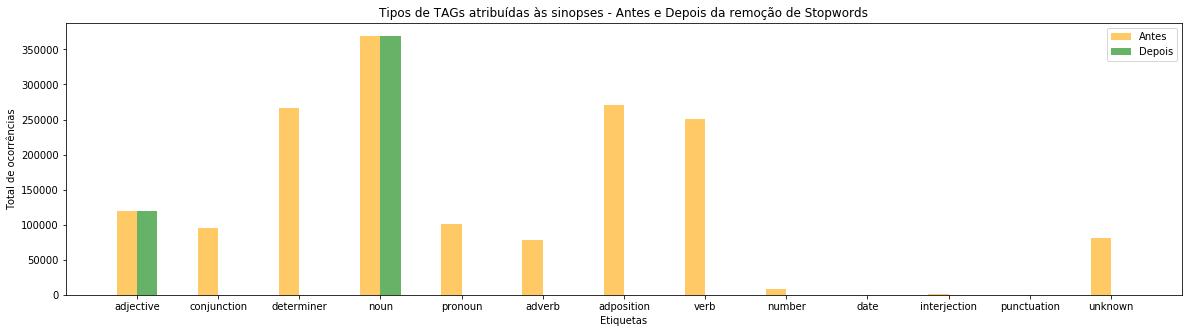

adjective=0.00039423907664171143
conjunction=1.0
determiner=1.0
noun=0.0007095924989031221
pronoun=1.0
adverb=1.0
adposition=1.0
verb=1.0
number=1.0
date=nan
interjection=1.0
punctuation=nan
unknown=1.0


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars


In [24]:
etiquetasAntes = ('adjective_before','conjunction_before','determiner_before','noun_before','pronoun_before','adverb_before','adposition_before','verb_before','number_before','date_before','interjection_before','punctuation_before','unknown_before')
etiquetasDepois = ('adjective_after','conjunction_after','determiner_after','noun_after','pronoun_after','adverb_after','adposition_after','verb_after','number_after','date_after','interjection_after','punctuation_after','unknown_after')
eixoHorizontal = ('adjective','conjunction','determiner','noun','pronoun','adverb','adposition','verb','number','date','interjection','punctuation','unknown')

generateTagsPlot(etiquetasAntes,etiquetasDepois,eixoHorizontal,20,5,0.25,'Tipos de TAGs atribuídas às sinopses - Antes e Depois da remoção de Stopwords','Etiquetas','Total de ocorrências')

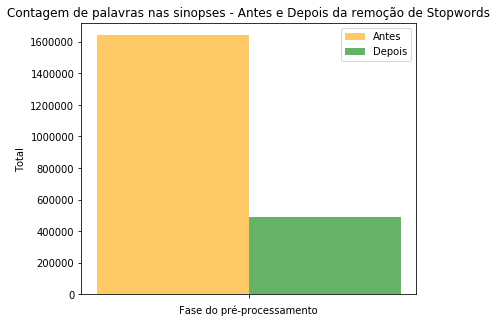

=0.7023676616117611


In [25]:
etiquetasAntesNew = ['total_before']
etiquetasDepoisNew = ['total_after']
eixoHorizontalNew = ['']

generateTagsPlot(etiquetasAntesNew,etiquetasDepoisNew,eixoHorizontalNew,6,5,0.25,'Contagem de palavras nas sinopses - Antes e Depois da remoção de Stopwords','Fase do pré-processamento','Total')

In [4]:
#Import CSV file to a DataFrame
df = pd.read_csv(filePath+'dataSetComPosTaggingDepoisDaRemocaoDeStopwords.csv')
df = df.drop(['Unnamed: 0'],1)

In [5]:
df['titulo'] = [titulo.lower() for titulo in df['titulo']]
df = df.drop_duplicates(subset=['titulo'],keep='first',inplace=False)

In [6]:
df.to_csv(filePath+'datasetSemTitulosDuplicados.csv')
with open(filePath+'logDatasetSemTitulosDuplicados.txt','w') as log:
    log.write(extractStatisticsFromSynopsis(df, "Statistics of Dataset - Removing duplicated titles", 'synopsisWithoutStopwords'))